# The New TensorFlow Ecosystem


## (Or how I learned to stop worrying and love the bomb)

## Why TensorFlow?
- Community: plenty of code out there to... borrow
- When done properly, it's fast

## Why Keras?
- Fast extensibility and customizability for TensorFlow, especially for recurrent models
- Addresses a lot of the reasons *not* to use TF

## Why not Horovod?
- Distribution API great for single node
- Reduces dependencies, one less thing to keep up-to-date

## The way things was
- TensorFlow pipelines required a lot of recycling custom scaffolding. Lack of APIs or clear organization
- Keras helped, but required completely separate scaffolding. Didn't play great with standalone TF
- Distribution for both was really bad without Horovod

## The way things is
- Estimator, Dataset, and Distribution APIs clearly defined, handle things efficiently under the hood
- Plays great with Keras. Allows for fast prototyping of new models structures
- Effortless near-linear distribution on single node

## Long way to go
- Still lacking lots of features like learning rate scheduling and Keras model subclassing
- TensorFlow documentation can be confusing/lacking/non-standard in its language
- Still, represents a popular and reasonably simple way to build and train complicated models quickly
- Worth understanding the various pieces and how they play together

# TensorFlow Speech Recognition Challenge
Classify the single word spoken in 1 second audio clips

<img src="img/tf-src.png" width="70%" style="position:relative;top:-100px;left:200px"></img>

## TensorFlow Speech Recognition Challenge

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
import IPython.display as ipd
import tensorflow as tf
import numpy as np
import warnings

warnings.simplefilter('ignore')
tf.logging.set_verbosity(0)

## TensorFlow Speech Recognition Challenge

In [2]:
dataset = tf.data.TFRecordDataset('/data/train.tfrecords')
def parser(record):
    features = {
        'spec': tf.FixedLenSequenceFeature((), tf.float32, allow_missing=True),
        'label': tf.FixedLenFeature((), tf.string, default_value="")
    }
    parsed = tf.parse_single_example(record, features)
    spec = tf.reshape(parsed['spec'], [99, 161])
    return spec, parsed['label']

dataset = dataset.shuffle(10000)
dataset = dataset.map(parser)
dataset = dataset.batch(1)

iterator = dataset.make_one_shot_iterator()
spectrogram, filename = iterator.get_next()

## TensorFlow Speech Recognition Challenge
Dataset objects, like everything else in a TensorFlow graph, are *symbolic*. They don't have any "real" value until we run them in a TensorFlow `Session`.

In [3]:
sess = tf.Session()
spec, fname = sess.run([spectrogram, filename])

sample_rate, waveform = wavfile.read(fname[0])
word = str(fname[0]).split("/")[-2].title()
print('Word: {}'.format(word))
ipd.Audio(data=waveform, rate=sample_rate)

Word: No


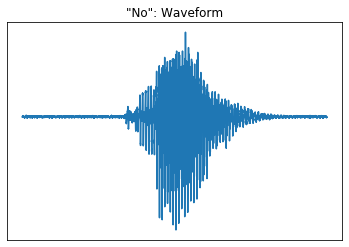

In [4]:
fig, ax = plt.subplots()
ax.plot(waveform)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.set_title('"{}": Waveform'.format(word))
fig.show()

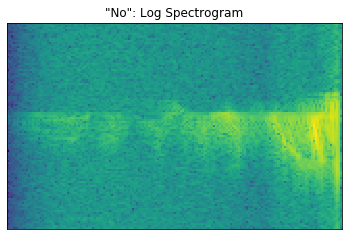

In [ ]:
fig, ax = plt.subplots()
ax.imshow(spec[0,:,::-1])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title('"{}": Log Spectrogram'.format(word))
fig.show()

# Things We Need

### 1. A Model

# Things We Need
## 1. A Model - Keras!

## A Model

- Spectrogram looks like an image, use a CNN?

- Lots of good reasons to do this (local information, accounting for "high" and "low" voices, etc.)

- But...

<img src=https://media.giphy.com/media/4KMduk6fuPJTi/giphy.gif style="position:relative;top:-80px"></img>

## A Model

- Baidu <a href=https://arxiv.org/abs/1412.5567>Deep Speech</a>
- Recurrent model for end to end speech recognition
- Meant for sequence to sequence with different loss function, but forces us to get more creative with `tf.keras`

<img src=img/deepspeech.PNG width="75%"></img>

## A Model

- Need to build custom layers
- First rolls consecutive spectrogram frames into single timestep
- Second does custom forward and backward recurrence with shared parameters
- This is where Keras shines

<img src=img/deepspeech.PNG width="75%"></img>

## Custom Layers - Concatenate consecutive frames

In [ ]:
class ImageToDeepSpeech(tf.keras.layers.Layer):
    def __init__(self, num_frames, frame_step, **kwargs):
        self.num_frames = num_frames
        self.frame_step = frame_step
        super(ImageToDeepSpeech, self).__init__(**kwargs)

    def call(self, inputs):
        inputs = tf.squeeze(inputs, axis=3)
        time_slice = lambda x, i: x[:, i:(-(self.num_frames-1)+i) or None:self.frame_step]
        time_shifted_inputs = [time_slice(inputs, i) for i in range(self.num_frames)]
        return tf.concat(time_shifted_inputs, axis=2)

    def compute_output_shape(self, input_shape):
        shape = tf.TensorShape(input_shape).as_list()
        time_dim = tf.ceil((shape[1] - self.num_frames + 2) / self.frame_step)
        feature_dim = self.num_frames*shape[2]
        if self.frame_step == 1:
            time_dim += 1
        return tf.TensorShape([shape[0], time_dim, feature_dim])

    def get_config(self):
        base_config = super(ImageToDeepSpeech, self).get_config()
        base_config['num_frames'] = self.num_frames
        base_config['frame_step'] = self.frame_step
        return base_config

## Custom Layer - Custom Recurrent Cell
Only have to define recurrent step like regular layer. RNN wrapper takes care of rest

In [ ]:
class DeepSpeechCell(tf.keras.layers.Layer):
    def __init__(self, state_size, **kwargs):
        self.state_size = state_size
        super(DeepSpeechCell, self).__init__(**kwargs)

    def call(self, inputs, states):
        prev_output = states[0]
        h = tf.matmul(inputs, self.kernel)
        u = tf.matmul(prev_output, self.recurrent_kernel)
        output = tf.nn.relu(h + u + self.bias)
        return output, [output]

    def build(self, input_shape):
        self.input_dim = input_shape[1]
        if self.built:
            # normally you just return. This is a hack to allow the
            # second calling of this cell to use a different recurrent
            # kernel. Not elegant but that's showbiz baby
            self.recurrent_kernel = self.backward_recurrent_kernel
            return

        self.kernel = self.add_weight(
            shape=(self.input_dim, self.state_size),
            name='kernel',
            initializer='glorot_normal')
        self.bias = self.add_weight(
            shape=(self.state_size,),
            name='bias',
            initializer='zeros')

        self.forward_recurrent_kernel = self.add_weight(
            shape=(self.state_size, self.state_size),
            name='forward_recurrent_kernel',
            initializer='glorot_normal')
        self.backward_recurrent_kernel = self.add_weight(
            shape=(self.state_size, self.state_size),
            name='backward_recurrent_kernel',
            initializer='glorot_normal')

        self.recurrent_kernel = self.forward_recurrent_kernel
        super(DeepSpeechCell, self).build(input_shape)

    def get_config(self):
        base_config = super(DeepSpeechCell, self).get_config()
        base_config['state_size'] = self.state_size
        return base_config

## A Model

In [ ]:
def deepspeech_model(
        num_frames,
        frame_step,
        hidden_dims,
        num_classes,
        dropout=0.05):
    # input and convert from image to time series representation
    input = tf.keras.Input(shape=(99, 161, 1), name='spec')
    x = ImageToDeepSpeech(num_frames, frame_step)(input)

    # transform with 3 time distributed dense layers
    for n, hdim in enumerate(hidden_dims[:3]):
        x = tf.keras.layers.Dropout(dropout, name='dropout_{}'.format(n))(x)
        dense = tf.keras.layers.Dense(hdim, activation='relu')
        x = tf.keras.layers.TimeDistributed(dense, name='dense_{}'.format(n))(x)

    # perform forwards and backwards recurrent layers then combine
    # note that we're not returning sequences, so we're going from shape
    # B x T x F --> B x F
    cell = DeepSpeechCell(hidden_dims[3])
    forward = tf.keras.layers.RNN(cell, return_sequences=False, name='forward_rnn')(x)
    backward = tf.keras.layers.RNN(cell, return_sequences=False, go_backwards=True, name='backward_rnn')(x)
    x = tf.keras.layers.Add(name='rnn_combiner')([forward, backward])

    # transform with more dense layers (now not time distributed)
    for n, hdim in enumerate(hidden_dims[4:]):
        x = tf.keras.layers.Dropout(dropout, name='dropout_{}'.format(n+3))(x)
        x = tf.keras.layers.Dense(hdim, activation='relu', name='dense_{}'.format(n+3))(x)

    # produce output
    x = tf.keras.layers.Dropout(dropout, name='dropout_labels')(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax', name='labels')(x)
    return tf.keras.Model(inputs=input, outputs=x)

# Things We Need
## 1. A Model - Keras!

## 2. A Data Pipeline

# Things We Need
## 1. A Model - Keras!
## 2. A Data Pipeline - Dataset API!

## A Data Pipeline

In [ ]:
import multiprocessing as mp
num_cpus = mp.cpu_count()

def input_fn(
        dataset_path,
        labels,
        batch_size,
        num_epochs,
        input_shape,
        stats=None,
        eps=0.0001,
        buffer_size=50000,
        go_fast=False):
    dataset = tf.data.TFRecordDataset([dataset_path])
    table = tf.contrib.lookup.index_table_from_tensor(
        mapping=tf.constant(labels),
        num_oov_buckets=1)

    # load in pixel wise mean and variance
    if stats is not None:
        iterator = tf.python_io.tf_record_iterator(stats)
        features = {
            'mean': tf.FixedLenSequenceFeature((), tf.float32, allow_missing=True),
            'var': tf.FixedLenSequenceFeature((), tf.float32, allow_missing=True)}
        parsed = tf.parse_single_example(next(iterator), features)

        mean = tf.reshape(parsed['mean'], input_shape)
        std = tf.reshape(parsed['var']**0.5, input_shape) # square rooting the variance

    def parse_spectrogram(record):
        features = {
            'spec': tf.FixedLenSequenceFeature((), tf.float32, allow_missing=True),
            'label': tf.FixedLenFeature((), tf.string, default_value="")}
        parsed = tf.parse_single_example(record, features)

        # preprocess and normalize spectrogrm
        spec = tf.reshape(parsed['spec'], input_shape) # Time steps x Frequency bins
        if stats is not None:
            spec = (spec - mean) / (std + eps)
        spec = tf.expand_dims(spec, axis=2) # add channel dimension, T x F x 1

        label = tf.string_split([parsed['label']], delimiter="/").values[-2:-1]
        label = table.lookup(label)[0]
        label = tf.one_hot(label, len(labels)+1)
        return (spec, label)

    # naive approach
    if not go_fast:
        dataset = dataset.shuffle(buffer_size=buffer_size)
        dataset = dataset.repeat(num_epochs)
        dataset = dataset.map(parse_spectrogram, num_parallel_calls=num_cpus)
        dataset = dataset.batch(batch_size)

    else:
        dataset = dataset.apply(
            tf.data.experimental.shuffle_and_repeat(buffer_size, num_epochs))
        dataset = dataset.apply(
            tf.data.experimental.map_and_batch(
                map_func=parse_spectrogram,
                batch_size=batch_size,
                num_parallel_calls=num_cpus))
        dataset.prefetch(buffer_size=None)

    return dataset

# Things We Need
## 1. A Model - Keras!
## 2. A Data Pipeline - Dataset API!

## 3. A Trainer

# Things We Need
## 1. A Model - Keras!
## 2. A Data Pipeline - Dataset API!
## 3. A Trainer - Estimator API!

## A Trainer
Define some hyperparameters for training

In [ ]:
# Data info
DATA_DIR = os.environ['DATA_DIR']
TRAIN_DATA = '{}/train.tfrecords'.format(DATA_DIR)
VALID_DATA = '{}/valid.tfrecords'.format(DATA_DIR)
PIXEL_WISE_STATS = '{}/stats.tfrecords'.format(DATA_DIR)
LABELS = '{}/labels.txt'.format(DATA_DIR)
NUM_TRAIN_SAMPLES = 51088
INPUT_SHAPE = [99, 161]

# Model hyperparameters
NUM_FRAMES = 7
FRAME_STEP = 2
HIDDEN_SIZES = [1024, 2048, 2048, 1024, 2048]

# Training hyperparameters
BATCH_SIZE = 512
NUM_GPUS = 1
NUM_EPOCHS = 25
MAX_STEPS = NUM_EPOCHS*NUM_TRAIN_SAMPLES // (BATCH_SIZE*NUM_GPUS)
LEARNING_RATE = 2e-5 * NUM_GPUS
DROPOUT = 0.05
EVAL_THROTTLE_SECS = 120
LOG_STEPS = 10
MODEL_DIR = os.environ['MODEL_DIR']

print('Training for {} steps'.format(MAX_STEPS))

Training for 2494 steps


## A Trainer
Quick hack so we can rerun things in the same model dir each time without having to restart tensorboard

In [ ]:
! if ! [ -z "$(ls $MODEL_DIR)" ]; then rm -r $MODEL_DIR/*; fi

## A Trainer
Build and compile a tf.keras model using our model function from earlier

In [ ]:
with open(LABELS, 'r') as f:
    labels = f.read().split(",")
    labels = labels[:20]

model = deepspeech_model(NUM_FRAMES, FRAME_STEP, HIDDEN_SIZES, len(labels)+1, DROPOUT)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

## A Trainer

In [ ]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spec (InputLayer)               (None, 99, 161, 1)   0                                            
__________________________________________________________________________________________________
image_to_deep_speech (ImageToDe (None, 47, 1127)     0           spec[0][0]                       
__________________________________________________________________________________________________
dropout_0 (Dropout)             (None, 47, 1127)     0           image_to_deep_speech[0][0]       
__________________________________________________________________________________________________
dense_0 (TimeDistributed)       (None, 47, 1024)     1155072     dropout_0[0][0]                  
__________________________________________________________________________________________________
dropout_1 

## A Trainer
Convert our tf.keras model to a TensorFlow estimator

In [ ]:
# single GPU config
config_args = dict(
    save_summary_steps=LOG_STEPS,
    save_checkpoints_secs=EVAL_THROTTLE_SECS,
    log_step_count_steps=LOG_STEPS,
    model_dir=MODEL_DIR
)

# BREAK IN CASE OF EMERGENCY
# strategy = tf.contrib.distribute.MirroredStrategy(num_gpus=NUM_GPUS, prefetch_on_device=True)
# strategy = tf.contrib.distribute.DistributeConfig(train_distribute=strategy)
# config_args['experimental_distribute'] = strategy

custom_objects = {
    'DeepSpeechCell': DeepSpeechCell,
    'ImageToDeepSpeech': ImageToDeepSpeech}
estimator = tf.keras.estimator.model_to_estimator(
    model,
    custom_objects=custom_objects,
    config=tf.estimator.RunConfig(**config_args))

## A Model
Build a custom hook to monitor total throughput in samples/sec

In [ ]:
class ThroughputHook(tf.train.StepCounterHook):
    def __init__(self, batch_size, **kwargs):
        self.batch_size = batch_size
        super(ThroughputHook, self).__init__(**kwargs)

    def begin(self):
        super(ThroughputHook, self).begin()
        self._summary_tag = 'throughput'

    def _log_and_record(self, elapsed_steps, elapsed_time, global_step):
        super(ThroughputHook, self)._log_and_record(
            elapsed_steps*self.batch_size,
            elapsed_time,
            global_step)

hooks = [ThroughputHook(BATCH_SIZE*NUM_GPUS, every_n_steps=LOG_STEPS, output_dir=estimator.model_dir)]

## A Trainer
Build our input functions and train the model!

In [ ]:
GO_FAST = False # set to True in case of emergency
train_spec = tf.estimator.TrainSpec(
    input_fn=lambda : input_fn(
        TRAIN_DATA,
        labels,
        BATCH_SIZE,
        NUM_EPOCHS,
        INPUT_SHAPE,
        stats=PIXEL_WISE_STATS,
        go_fast=GO_FAST),
    max_steps=MAX_STEPS,
    hooks=hooks)

eval_spec = tf.estimator.EvalSpec(
    input_fn=lambda : input_fn(
        VALID_DATA,
        labels,
        BATCH_SIZE*8,
        1,
        INPUT_SHAPE,
        stats=PIXEL_WISE_STATS,
        go_fast=GO_FAST),
    throttle_secs=EVAL_THROTTLE_SECS)

tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

# Things We Need
## 1. A Model - Keras!
## 2. A Data Pipeline - Dataset API!
## 3. A Trainer - Estimator API!

## 4. Multi-GPU trainer

# Things We Need
## 1. A Model - Keras!
## 2. A Data Pipeline - Dataset API!
## 3. A Trainer - Estimator API!
## 4. Multi-GPU trainer -  Distribution API!

## Multi-GPU
Go back to slides above and uncomment the "Break in case of emergency" lines, and comment out their existing analogs. Change NUM_GPUs to 4, then click "Kernel->Restart & Run All" in the menu bar up top. How does throughput change as we multiply the number of GPUs by 4?